In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm.notebook import tqdm

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchvision.utils import make_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
SEED = 17
seed_everything(SEED)

# Data Folder

In [6]:
data_dir = '../input/cassava-leaf-disease-classification'
train_dir = data_dir + '/train_images'
train_csv = data_dir + '/train.csv'
test_dir = data_dir + '/test_images'
name_json = data_dir + '/label_num_to_disease_map.json'
sample_csv = data_dir + '/sample_submission.csv'

# Focal Loss

In [7]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

# Read CSV

In [8]:
train_df = pd.read_csv(train_csv)
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:
train_df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [10]:
train_df.label.value_counts() / len(train_df)

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

the dataset seems heavily unbalanced towards label 3.

# Dataset

In [11]:
class CassavaDS(Dataset):
    def __init__(self, df, data_dir, transforms=None):
        super().__init__()
        self.df_data = df.values
        self.transforms = transforms
        self.data_dir = data_dir

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            image = self.transforms(img)
        return image, label

In [12]:
# length = len(train_df)

In [13]:
# 0.14 * 0.1 * length

In [14]:
# cutoff = {'0': 0.23 * length, '1': 0.23 * length, '2': 0.23 * length, '3': 0.14 * length, '4':0.23 * length}

In [15]:
label_0_df = train_df[train_df['label'] == 0]
val_label_0 = label_0_df.apply(lambda x: x.sample(n=492, random_state=42)).reset_index(drop=True)
train_label_0 = label_0_df.apply(lambda x: x.sample(n=(len(label_0_df) - 492), random_state=42)).reset_index(drop=True)

label_1_df = train_df[train_df['label'] == 1]
val_label_1 = label_1_df.apply(lambda x: x.sample(n=492, random_state=42)).reset_index(drop=True)
train_label_1 = label_1_df.apply(lambda x: x.sample(n=(len(label_1_df) - 492), random_state=42)).reset_index(drop=True)

label_2_df = train_df[train_df['label'] == 2]
val_label_2 = label_2_df.apply(lambda x: x.sample(n=492, random_state=42)).reset_index(drop=True)
train_label_2 = label_2_df.apply(lambda x: x.sample(n=(len(label_2_df) - 492), random_state=42)).reset_index(drop=True)

label_3_df = train_df[train_df['label'] == 3]
val_label_3 = label_3_df.apply(lambda x: x.sample(n=300, random_state=42)).reset_index(drop=True)
train_label_3 = label_3_df.apply(lambda x: x.sample(n=(len(label_3_df) - 600), random_state=42)).reset_index(drop=True)

label_4_df = train_df[train_df['label'] == 4]
val_label_4 = label_4_df.apply(lambda x: x.sample(n=492, random_state=42)).reset_index(drop=True)
train_label_4 = label_4_df.apply(lambda x: x.sample(n=(len(label_4_df) - 492), random_state=42)).reset_index(drop=True)

X_train = pd.concat([train_label_0, train_label_1, train_label_2, train_label_3, train_label_4]).reset_index(drop=True)
X_valid = pd.concat([val_label_0, val_label_1, val_label_2, val_label_3, val_label_4]).reset_index(drop=True)

In [16]:
# X_train, X_valid = train_test_split(train_df, test_size=0.1, 
#                                                     random_state=SEED)

# from sklearn.model_selection import GroupShuffleSplit
# gs = GroupShuffleSplit(n_splits=7, test_size=0.2, random_state=SEED)
# train_indices, valid_indices = next(gs.split(train_df, groups=train_df.label.values))

In [17]:
X_train.shape, X_valid.shape

((18829, 2), (2268, 2))

In [18]:
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [19]:
train_tf = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    normalize
])

valid_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [20]:
train_ds = CassavaDS(X_train, train_dir, train_tf)
valid_ds = CassavaDS(X_valid, train_dir, valid_tf)

In [21]:
bs = 64

In [22]:
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=bs, shuffle=True)

# Labels

In [23]:
import json

with open(name_json, 'r') as f:
    cat_to_name = json.load(f)

In [24]:
cat_to_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

# Plot Images

In [25]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [26]:
unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [27]:
def display_img(img, label=None, unnorm_obj=None, invert=True, return_label=True):
    if unnorm_obj != None:
        img = unnorm_obj(img)

    plt.imshow(img.permute(1, 2, 0))
    
    if label != None:
        plt.title(cat_to_name[str(label)])

In [28]:
def display_batch(batch, unnorm_obj=None):    
    imgs, labels = batch
    
    if unnorm_obj:
        unnorm_imgs = []
        for img in imgs:
            unnorm_imgs.append(unnorm_obj(img))
        imgs = unnorm_imgs
    
    ig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(imgs, nrow=16).permute(1, 2, 0))

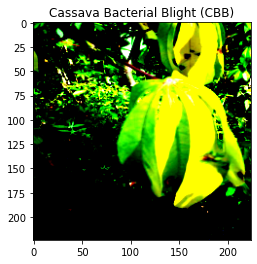

In [29]:
img, label = train_ds[0]
display_img(img, label)

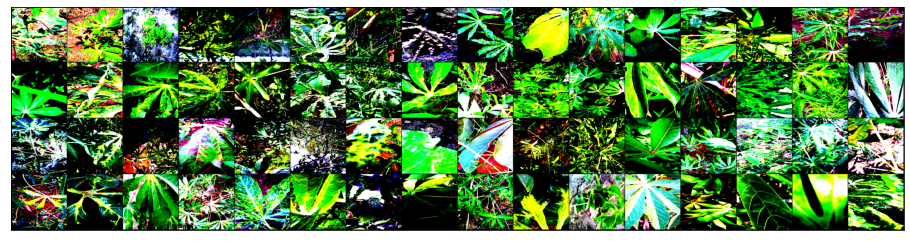

In [30]:
display_batch(next(iter(train_loader)))

# Helper Functions

In [31]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [32]:
def save_checkpoint(model, is_best, filename='./checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [33]:
def load_checkpoint(model, filename = './checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

In [34]:
def prec_recall_fscore(input, targs):
    scores = precision_recall_fscore_support(targs.cpu(), input.cpu(), average='macro')
    return {'precision': scores[0], 'recall': scores[1], 'fscore': scores[2], 'support': scores[3]} # return dictionary of 4 values

def print_prec_recall_fscore(scores):
    print("Precision Recall FScores Metric:")
    print(scores)
    
    return scores

# Train and Test

In [35]:
def train(loader, model, optimizer, device):
    model.train()
    correct, trn_loss, trn_time = 0., 0., 0
    t = tqdm(loader, leave=False, total=len(loader))
    bt_start = time.time()
    for i, (ip, target) in enumerate(t):
        ip, target = ip.to(device), target.to(device)                          
        output = model(ip)
        loss = criterion(output, target)
        trn_loss += loss.item()
        
        # measure accuracy and record loss
        _, pred = output.max(dim=1)
        correct += torch.sum(pred == target.data)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    trn_time = time.time() - bt_start
    trn_acc = correct * 100 / len(loader.dataset)
    trn_loss /= len(loader)
    print_prec_recall_fscore(prec_recall_fscore(pred, target))
    return trn_acc, trn_loss, trn_time

In [36]:
def valid(loader, model, optimizer, device):
    model.eval()
    with torch.no_grad():
        correct, val_loss, val_time = 0., 0., 0
        t = tqdm(loader, leave=False, total=len(loader))
        bt_start = time.time()
        for i, (ip, target) in enumerate(t):
            ip, target = ip.to(device), target.to(device)                          
            output = model(ip)
            loss = criterion(output, target)
            val_loss += loss.item()

            # measure accuracy and record loss
            _, pred = output.max(dim=1)
            correct += torch.sum(pred == target.data)

        val_time = time.time() - bt_start
        val_acc = correct * 100 / len(loader.dataset)
        val_loss /= len(loader)
        print_prec_recall_fscore(prec_recall_fscore(pred, target))
        return val_acc, val_loss, val_time

In [37]:
def fit(model, sched, optimizer, device, epoch):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    best_acc = 0.
    for j in range(epoch):
        trn_acc, trn_loss, trn_time = train(train_loader, model, optimizer, device)
        trn_stat.append(trn_loss, trn_acc, trn_time)
        val_acc, val_loss, val_time = valid(valid_loader, model, optimizer, device)
        val_stat.append(val_acc, val_loss, val_time)
        if sched:
            sched.step()
        if val_acc > best_acc:
            best_acc = val_acc
            save_checkpoint(model, True, './best_model.pth')
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_loss, val_loss, trn_acc, val_acc))

# Vision Transformer

Using implementation from https://github.com/nachiket273/Vision_transformer_pytorch.git

Using weights from pretrained-model on Imagenet-1k <br>
File is available at https://www.kaggle.com/nachiket273/visiontransformerpretrainedimagenet1kweights

pytorch tpu kernel available @ https://www.kaggle.com/nachiket273/pytorch-tpu-vision-transformer

In [38]:
!cp ../input/visiontransformerpretrainedimagenet1kweights/vit.py .
!cp ../input/visiontransformerpretrainedimagenet1kweights/vit_16_224_imagenet1000.pth .

In [39]:
from vit import ViT

In [40]:
def get_model(out_features=5):
    model = ViT(224, 16, drop_rate=0.1)
    load_checkpoint(model, './vit_16_224_imagenet1000.pth')
    model.out = nn.Linear(in_features=model.out.in_features, out_features=5)
    for param in model.parameters():
        param.require_grad = True
    return model

In [41]:
model = get_model()

In [42]:
model = model.to(device)

In [43]:
trn_stat = AvgStats()
val_stat = AvgStats()

In [44]:
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()

In [45]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))

In [46]:
epochs = 20

In [47]:
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-3)

In [48]:
fit(model, sched, optimizer, device, epochs)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


Precision Recall FScores Metric:
{'precision': 0.6388888888888888, 'recall': 0.625, 'fscore': 0.6019607843137256, 'support': None}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Recall FScores Metric:
{'precision': 0.5842424242424242, 'recall': 0.6300000000000001, 'fscore': 0.5761764705882353, 'support': None}
1	0.64451742	1.16351701	77.07791138	56.08465576


Precision Recall FScores Metric:
{'precision': 0.9696969696969697, 'recall': 0.8333333333333334, 'fscore': 0.873015873015873, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7076923076923076, 'recall': 0.6821428571428572, 'fscore': 0.6193650793650793, 'support': None}
2	0.51186013	0.96127569	81.73561859	62.25749207


Precision Recall FScores Metric:
{'precision': 0.38181818181818183, 'recall': 0.4, 'fscore': 0.3904761904761905, 'support': None}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Recall FScores Metric:
{'precision': 0.727099567099567, 'recall': 0.7044444444444444, 'fscore': 0.6503743315508022, 'support': None}
3	0.48632750	0.84842590	82.54819489	69.48853302


Precision Recall FScores Metric:
{'precision': 0.9666666666666667, 'recall': 0.8888888888888888, 'fscore': 0.9157894736842106, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6866666666666668, 'recall': 0.6333333333333333, 'fscore': 0.6118181818181818, 'support': None}
4	0.46025141	0.90153980	84.02995300	64.24162292


Precision Recall FScores Metric:
{'precision': 0.6388888888888888, 'recall': 0.625, 'fscore': 0.6019607843137256, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.769047619047619, 'recall': 0.7944444444444444, 'fscore': 0.762088107970461, 'support': None}
5	0.44710404	0.74430549	84.25301361	71.20810699


Precision Recall FScores Metric:
{'precision': 0.5, 'recall': 0.5, 'fscore': 0.5, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8776470588235293, 'recall': 0.6466666666666667, 'fscore': 0.6735449735449736, 'support': None}
6	0.43245664	0.89458143	84.64602661	65.34391022


Precision Recall FScores Metric:
{'precision': 1.0, 'recall': 1.0, 'fscore': 1.0, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8044444444444444, 'recall': 0.7521428571428571, 'fscore': 0.7044494720965309, 'support': None}
7	0.41642548	0.88635445	85.23023224	67.37213135


Precision Recall FScores Metric:
{'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'fscore': 0.7777777777777777, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6799999999999999, 'recall': 0.7180952380952381, 'fscore': 0.668853238265003, 'support': None}
8	0.40462218	0.73386986	85.85160828	72.97177887


Precision Recall FScores Metric:
{'precision': 0.875, 'recall': 0.7916666666666666, 'fscore': 0.7996031746031745, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.66, 'recall': 0.5857142857142857, 'fscore': 0.5606060606060606, 'support': None}
9	0.39707470	0.79307307	86.07997894	69.17989349


Precision Recall FScores Metric:
{'precision': 1.0, 'recall': 1.0, 'fscore': 1.0, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6133333333333333, 'recall': 0.4488888888888889, 'fscore': 0.4609523809523809, 'support': None}
10	0.38073572	0.91539694	86.68543243	66.18165588


Precision Recall FScores Metric:
{'precision': 0.75, 'recall': 0.725, 'fscore': 0.736842105263158, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6976190476190476, 'recall': 0.6166666666666666, 'fscore': 0.5921212121212122, 'support': None}
11	0.36664799	0.67955789	87.09437561	74.69135284


Precision Recall FScores Metric:
{'precision': 0.35, 'recall': 0.3, 'fscore': 0.30476190476190473, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.858095238095238, 'recall': 0.788888888888889, 'fscore': 0.7728438228438228, 'support': None}
12	0.36125139	0.76645570	87.52455902	70.85537720


Precision Recall FScores Metric:
{'precision': 0.4545454545454546, 'recall': 0.5, 'fscore': 0.475, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8933333333333333, 'recall': 0.7761904761904762, 'fscore': 0.7977777777777777, 'support': None}
13	0.34771983	0.67285780	87.91757202	74.69135284


Precision Recall FScores Metric:
{'precision': 1.0, 'recall': 1.0, 'fscore': 1.0, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8833333333333332, 'recall': 0.8928571428571429, 'fscore': 0.8695238095238095, 'support': None}
14	0.33615732	0.69317336	88.23091888	73.10405731


Precision Recall FScores Metric:
{'precision': 0.5694444444444444, 'recall': 0.4444444444444444, 'fscore': 0.48611111111111105, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8092857142857144, 'recall': 0.846111111111111, 'fscore': 0.8011904761904762, 'support': None}
15	0.32504264	0.66015319	88.62393188	74.82363129


Precision Recall FScores Metric:
{'precision': 1.0, 'recall': 1.0, 'fscore': 1.0, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8097402597402598, 'recall': 0.74, 'fscore': 0.730542264752791, 'support': None}
16	0.31451714	0.66798019	88.92134094	75.66137695


Precision Recall FScores Metric:
{'precision': 0.3333333333333333, 'recall': 0.3333333333333333, 'fscore': 0.3333333333333333, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7905555555555555, 'recall': 0.7555555555555555, 'fscore': 0.7024242424242424, 'support': None}
17	0.30402433	0.77557052	89.44181824	71.73721313


Precision Recall FScores Metric:
{'precision': 0.6380952380952382, 'recall': 0.7, 'fscore': 0.6179487179487179, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7557575757575756, 'recall': 0.7036363636363636, 'fscore': 0.6535574229691876, 'support': None}
18	0.30096843	0.73023347	89.57990265	73.05995941


Precision Recall FScores Metric:
{'precision': 0.5694444444444444, 'recall': 0.625, 'fscore': 0.5520833333333334, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.793939393939394, 'recall': 0.7216666666666667, 'fscore': 0.7183261183261183, 'support': None}
19	0.29379190	0.73484972	89.89324951	73.58906555


Precision Recall FScores Metric:
{'precision': 0.3333333333333333, 'recall': 0.3333333333333333, 'fscore': 0.3333333333333333, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8305555555555555, 'recall': 0.8222222222222223, 'fscore': 0.8240404040404041, 'support': None}
20	0.28439667	0.66894588	90.23315430	76.05819702


# Predict

In [49]:
test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [50]:
load_checkpoint(model, './best_model.pth')

In [51]:
def predict(test_dir, model, device):
    img_names = []
    preds = []
    for name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, name)
        img = Image.open(img_path).convert("RGB")
        img = test_tf(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        op = model(img)
        _, pred = op.max(dim=1)
        img_names.append(name)
        preds.append(pred.item())
    return img_names, preds

In [52]:
img_names, preds = predict(test_dir, model, device)

In [53]:
img_names, preds

(['2216849948.jpg'], [4])

In [54]:
# sub_df.head()

In [55]:
# sub_df['image_id'] = img_names
# sub_df['label'] = preds

In [56]:
# sub_df.head()

In [57]:
# sub_df.to_csv('submission.csv', index=False)